## DFO Si Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean

mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=12)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=12)
mpl.rc('font', size=12)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = ','.join(r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
%matplotlib inline

In [2]:
df=et.loadDFO()
df.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,NaN,12.0,1982-07-16 01:21:00
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,NaN,21.5,1982-07-16 01:21:00
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,NaN,30.5,1982-07-16 01:21:00
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,NaN,52.3,1982-07-16 01:21:00
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,NaN,75.4,1982-07-16 01:21:00


In [3]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    navlon=mesh.variables['nav_lon'][:,:]
    navlat=mesh.variables['nav_lat'][:,:]
    tmask=mesh.variables['tmask'][:,:,:,:]
    gdept=mesh.variables['gdept_1d'][0,:]
    e3t0=mesh.variables['e3t_0'][0,:,:,:]
bathy=np.sum(e3t0,0)
with nc.Dataset('/results/SalishSea/hindcast.201812/01jan16/SalishSea_1h_20160101_20160101_ptrc_T.nc') as ftemp:
        bounds=np.copy(ftemp.variables['deptht_bounds'][:,:])

In [4]:
#d1=et._gridHoriz(df.loc[df.Z>150].copy(deep=True),tmask,navlon,navlat,wrapSearch=False,resetIndex=True);
d1=et._gridHoriz(df.copy(deep=True),tmask,navlon,navlat,wrapSearch=False,resetIndex=True);
d1['k']=np.nan
for ind, row in d1.iterrows():
    ik=et._getZInd_bin(row['Z'],None,boundsFlag=True)
    if (not np.isnan(ik)) and (tmask[0,ik,row['j'],row['i']]==1):
        d1.loc[ind,['k']]=ik

(Lat,Lon)= 47.05 -122.31666666666666  not matched to domain
(Lat,Lon)= 47.1 -122.7  not matched to domain
(Lat,Lon)= 47.1 -122.68333333333334  not matched to domain
(Lat,Lon)= 47.166666666666664 -122.51666666666667  not matched to domain
(Lat,Lon)= 49.29933333333334 -122.983  not matched to domain
(Lat,Lon)= 49.30222166666667 -122.94861166666666  not matched to domain
(Lat,Lon)= 49.3025 -122.939445  not matched to domain
(Lat,Lon)= 49.3025 -122.93277833333333  not matched to domain
(Lat,Lon)= 49.304833333333335 -122.94116666666666  not matched to domain
(Lat,Lon)= 49.306945 -122.941945  not matched to domain
(Lat,Lon)= 49.30722166666666 -122.93527833333333  not matched to domain
(Lat,Lon)= 49.312778333333334 -122.94111166666667  not matched to domain
(Lat,Lon)= 49.312778333333334 -122.9325  not matched to domain
(Lat,Lon)= 50.47666666666667 -126.17833333333333  not matched to domain
(Lat,Lon)= 50.4882 -126.3484  not matched to domain
(Lat,Lon)= 50.49666666666667 -126.31166666666667  no

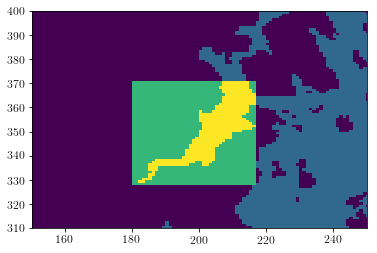

In [5]:
# drop Saanich Inlet
tmask2=np.copy(tmask[0,0,:,:])
tmask2[328:371,180:217]=tmask[0,0,328:371,180:217]+2
plt.pcolormesh(tmask2)
plt.xlim(150,250)
plt.ylim(310,400)
d1.drop(d1.loc[(d1.i>=180)&(d1.i<217)&(d1.j>=328)&(d1.j<371)].index.values,inplace=True)
# also drop east side Vancouver Island points:
d1.drop(d1.loc[(d1.i<10)&(d1.j>=460)&(d1.j<480)].index.values,inplace=True)

In [6]:
d1['YD']=[(dt.datetime(int(yy),int(mm),int(dd))-dt.datetime(int(yy),1,1)).total_seconds()/(24*3600) for yy,mm,dd in zip(d1['Year'].values,d1['Month'].values,d1['Day'].values)]

In [7]:
np.unique(d1.loc[(d1.N==0)&(d1.Z>20),['Year']])

array([2006.])

In [8]:
d1.loc[(d1.N==0)&(d1.Z>20)]

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,...,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC,j,i,k,YD
11627,2006.0,6.0,16.0,6.132222,49.443333,-124.337167,125.2,NaN,NaN,None,...,17.4,umol/L,30.487816,8.774221,124.095477,2006-06-16 06:07:56,567,183,27.0,166.0


In [9]:
d1.loc[(d1.Si==0)&(d1.Z>20)].head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,...,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC,j,i,k,YD
21422,1932.0,4.0,1.0,22.0,48.866667,-122.866667,NaN,30.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,30.0,1932-04-01 22:00:00,351,327,21.0,91.0
21423,1932.0,4.0,1.0,22.0,48.866667,-122.866667,NaN,50.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,50.0,1932-04-01 22:00:00,351,327,23.0,91.0
21424,1932.0,4.0,1.0,22.0,48.866667,-122.866667,NaN,100.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,100.0,1932-04-01 22:00:00,351,327,NaN,91.0
21425,1932.0,4.0,1.0,22.0,48.866667,-122.866667,NaN,180.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,180.0,1932-04-01 22:00:00,351,327,NaN,91.0
21433,1932.0,4.0,1.0,18.0,48.866667,-122.866667,NaN,30.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,30.0,1932-04-01 18:00:00,351,327,21.0,91.0


In [10]:
def binmean(ddf,latEdges,lonEdges):
    latbins=np.digitize(ddf.Lat,latEdges)
    lonbins=np.digitize(ddf.Lon,lonEdges)
    midLats=.5*(latEdges[:-1]+latEdges[1:])
    midLons=.5*(lonEdges[:-1]+lonEdges[1:])
    xxlon,xxlat=np.meshgrid(midLons,midLats)
    sums=np.zeros(np.shape(xxlon))
    counts=np.zeros(np.shape(xxlon))
    means=np.nan*np.ones(np.shape(xxlon))
    for jj in range(0,len(midLats)):
        for ii in range(0,len(midLons)):
            if len(ddf.loc[(latbins==jj+1)&(lonbins==ii+1),['Si']])>=1:
                means[jj,ii]=np.sum(ddf.loc[(latbins==jj+1)&(lonbins==ii+1),['Si']])/len(ddf.loc[(latbins==jj+1)&(lonbins==ii+1),['Si']])
    return xxlon, xxlat, means

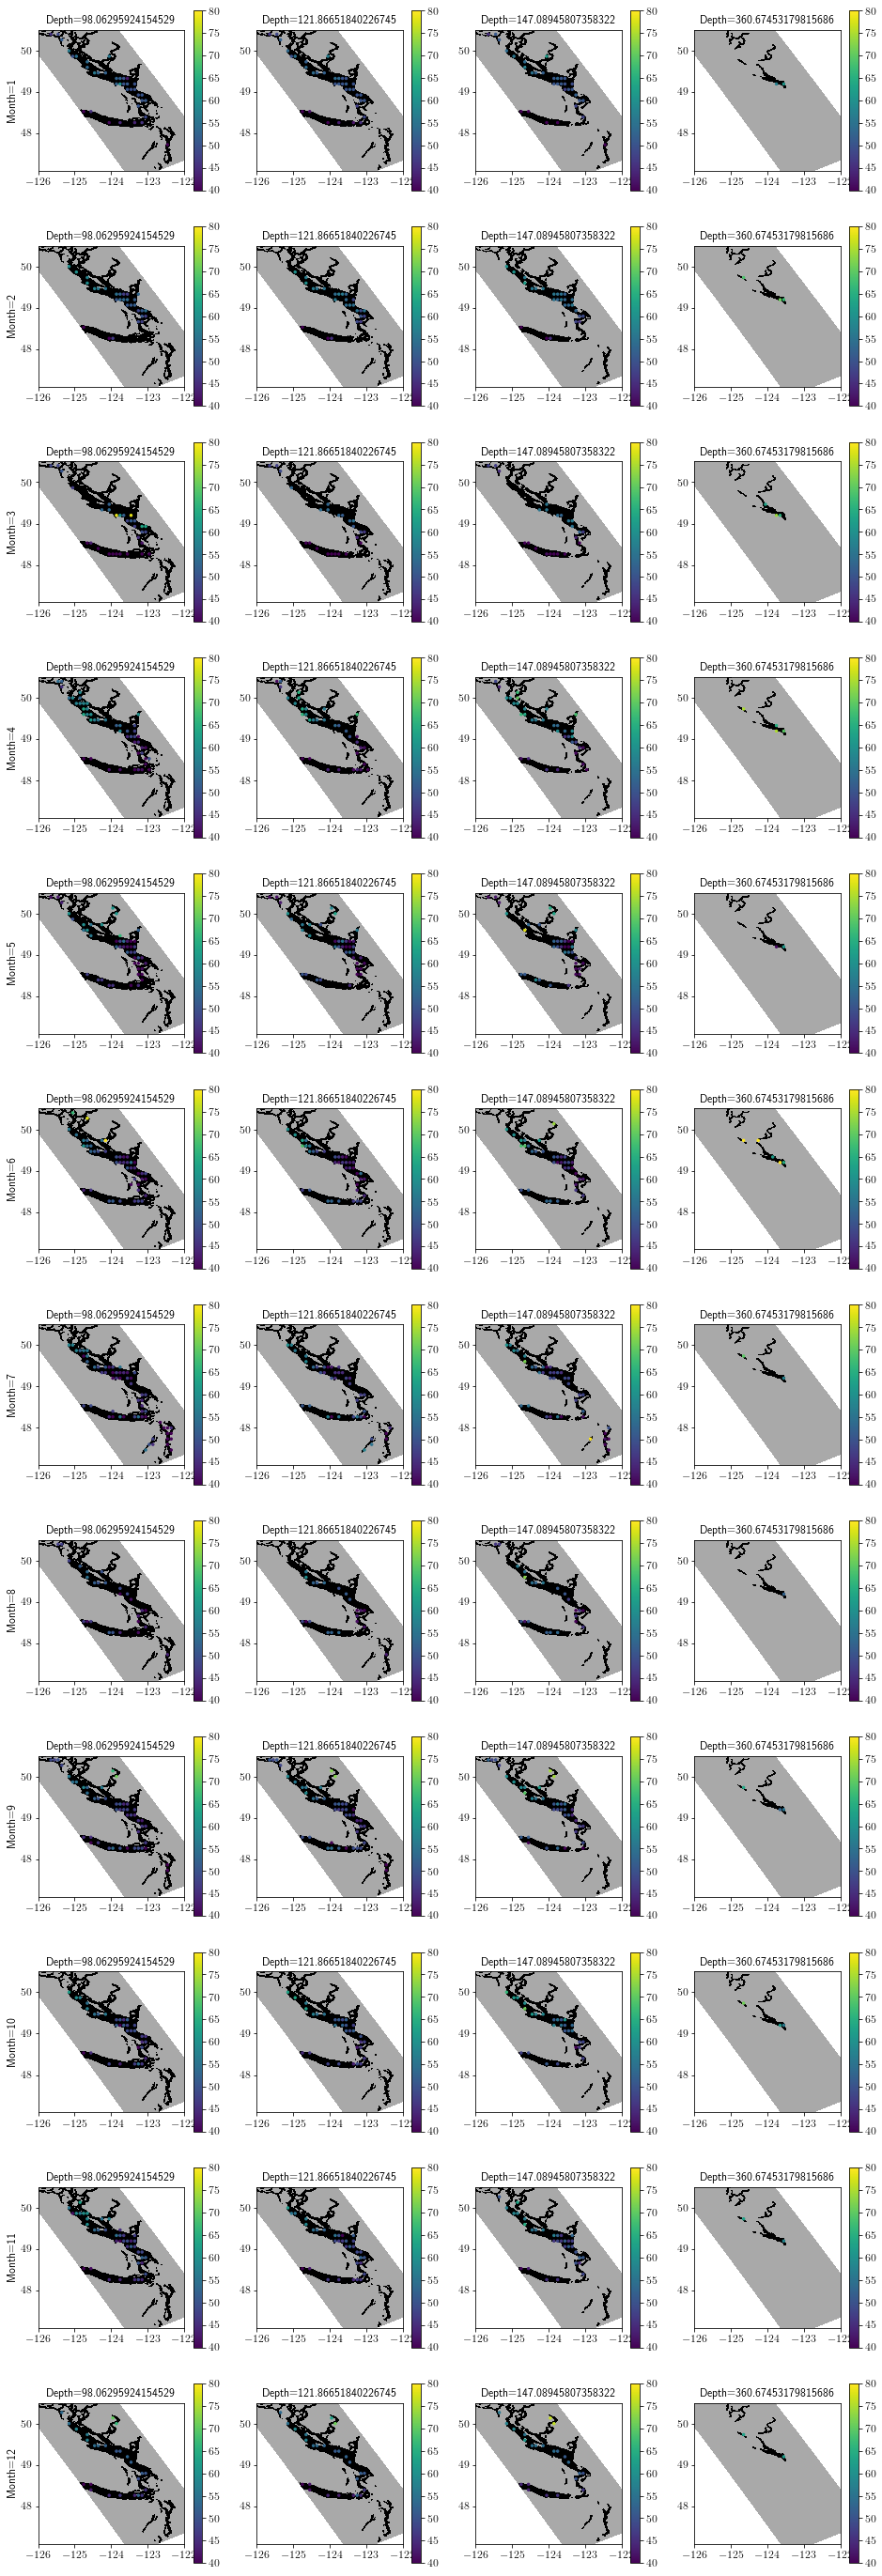

In [11]:
fig,ax=plt.subplots(12,4,figsize=(16,50))
#kk=30 #36,34,32,30
simin=40
simax=80
for mon in range(1,13):
    iax=ax[mon-1,0]
    kk=26
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    idf=d1.loc[(d1.k==kk)&(d1.Si>=0)&(d1.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_ylabel('Month='+str(mon))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,1]
    kk=27
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    idf=d1.loc[(d1.k==kk)&(d1.Si>=0)&(d1.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,2]
    kk=28
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    idf=d1.loc[(d1.k==kk)&(d1.Si>=0)&(d1.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,3]
    kk=36
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    idf=d1.loc[(d1.k==kk)&(d1.Si>=0)&(d1.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)

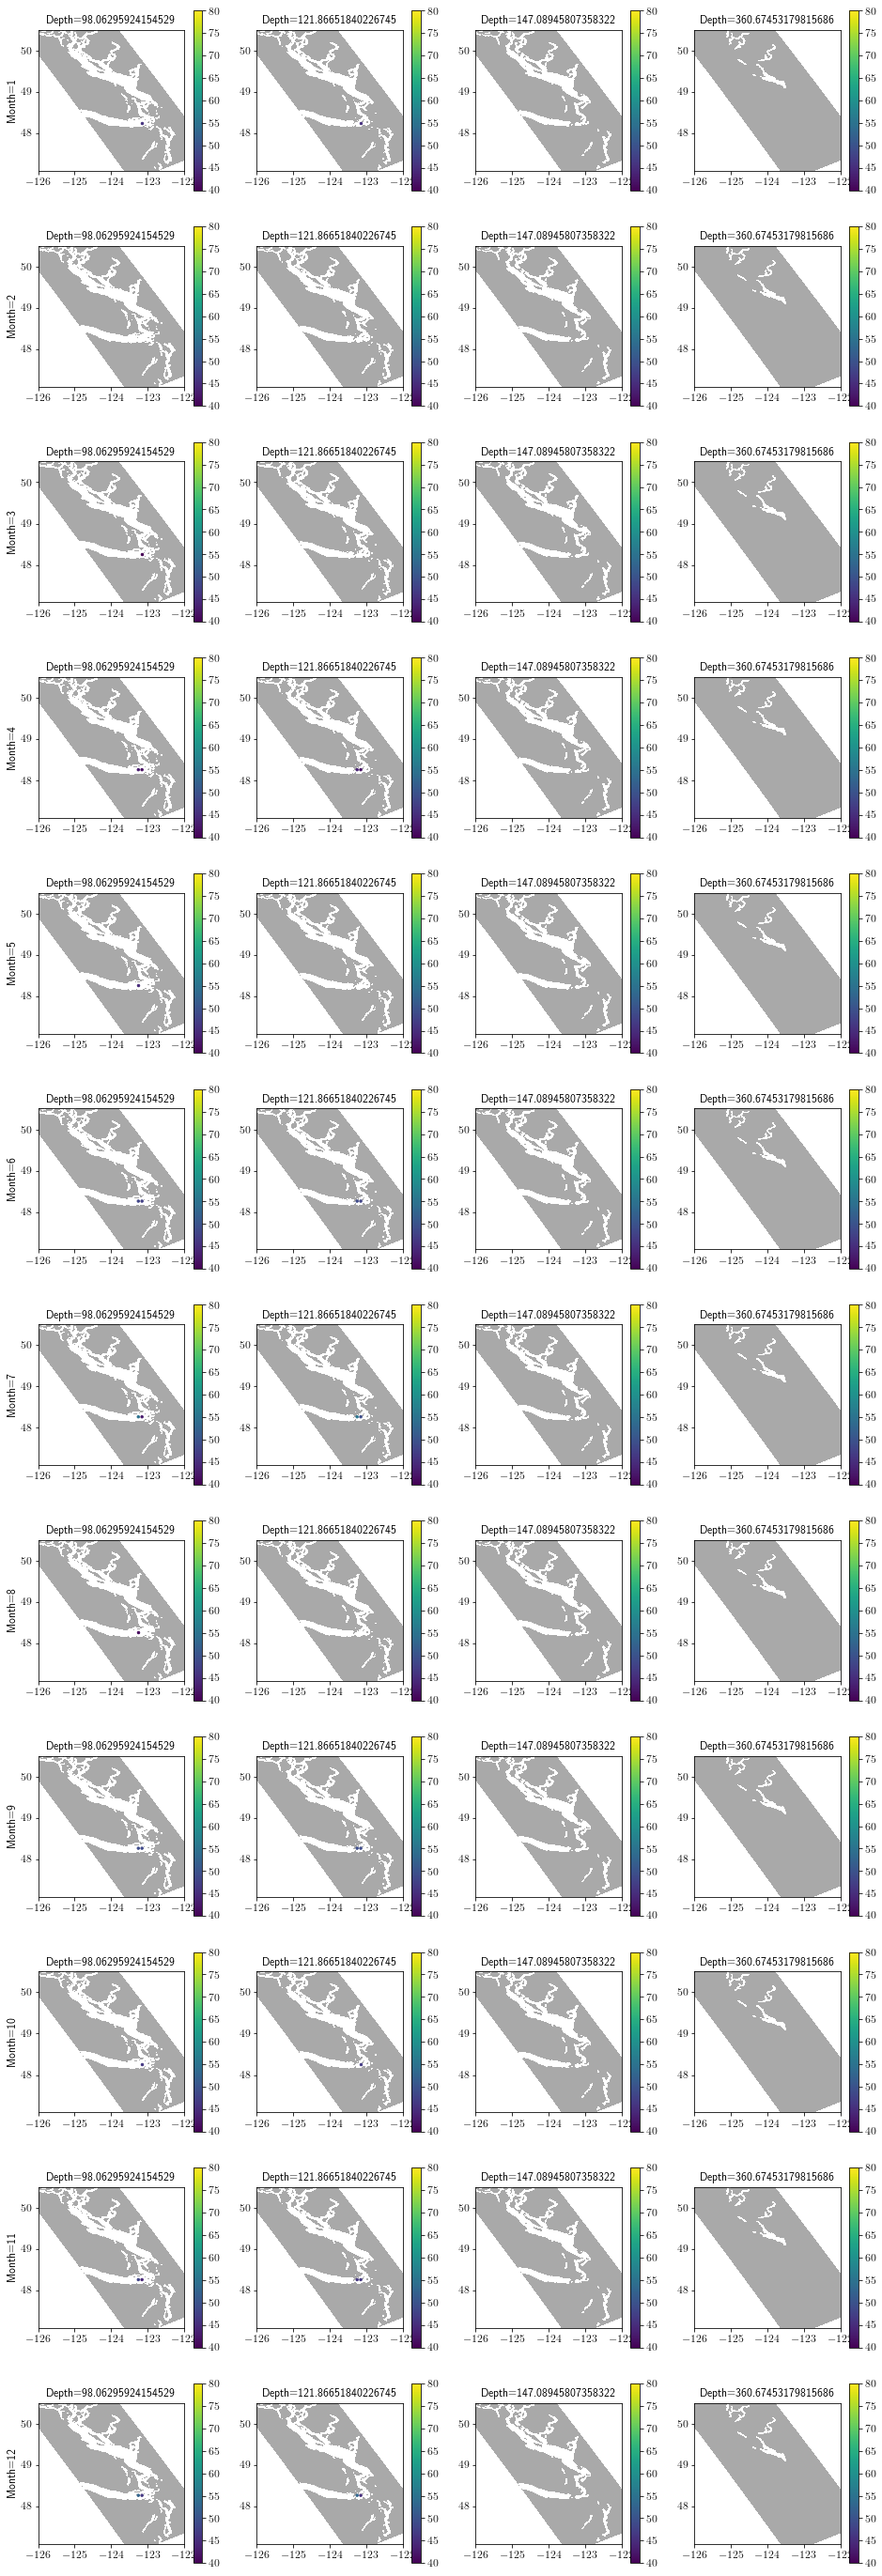

In [12]:
dfVic=d1.loc[(d1.Lat>48.15)&(d1.Lat<48.4)&(d1.Lon>-123.3)&(d1.Lon<-123.1)]
fig,ax=plt.subplots(12,4,figsize=(16,50))
#kk=30 #36,34,32,30
simin=40
simax=80
for mon in range(1,13):
    iax=ax[mon-1,0]
    kk=26
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','w','w'))
    viz_tools.set_aspect(iax,coords='map')
    idf=dfVic.loc[(dfVic.k==kk)&(dfVic.Si>=0)&(dfVic.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_ylabel('Month='+str(mon))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,1]
    kk=27
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','w','w'))
    viz_tools.set_aspect(iax,coords='map')
    idf=dfVic.loc[(dfVic.k==kk)&(dfVic.Si>=0)&(dfVic.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,2]
    kk=28
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','w','w'))
    viz_tools.set_aspect(iax,coords='map')
    idf=dfVic.loc[(dfVic.k==kk)&(dfVic.Si>=0)&(dfVic.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,3]
    kk=36
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','w','w'))
    viz_tools.set_aspect(iax,coords='map')
    idf=dfVic.loc[(dfVic.k==kk)&(dfVic.Si>=0)&(dfVic.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)

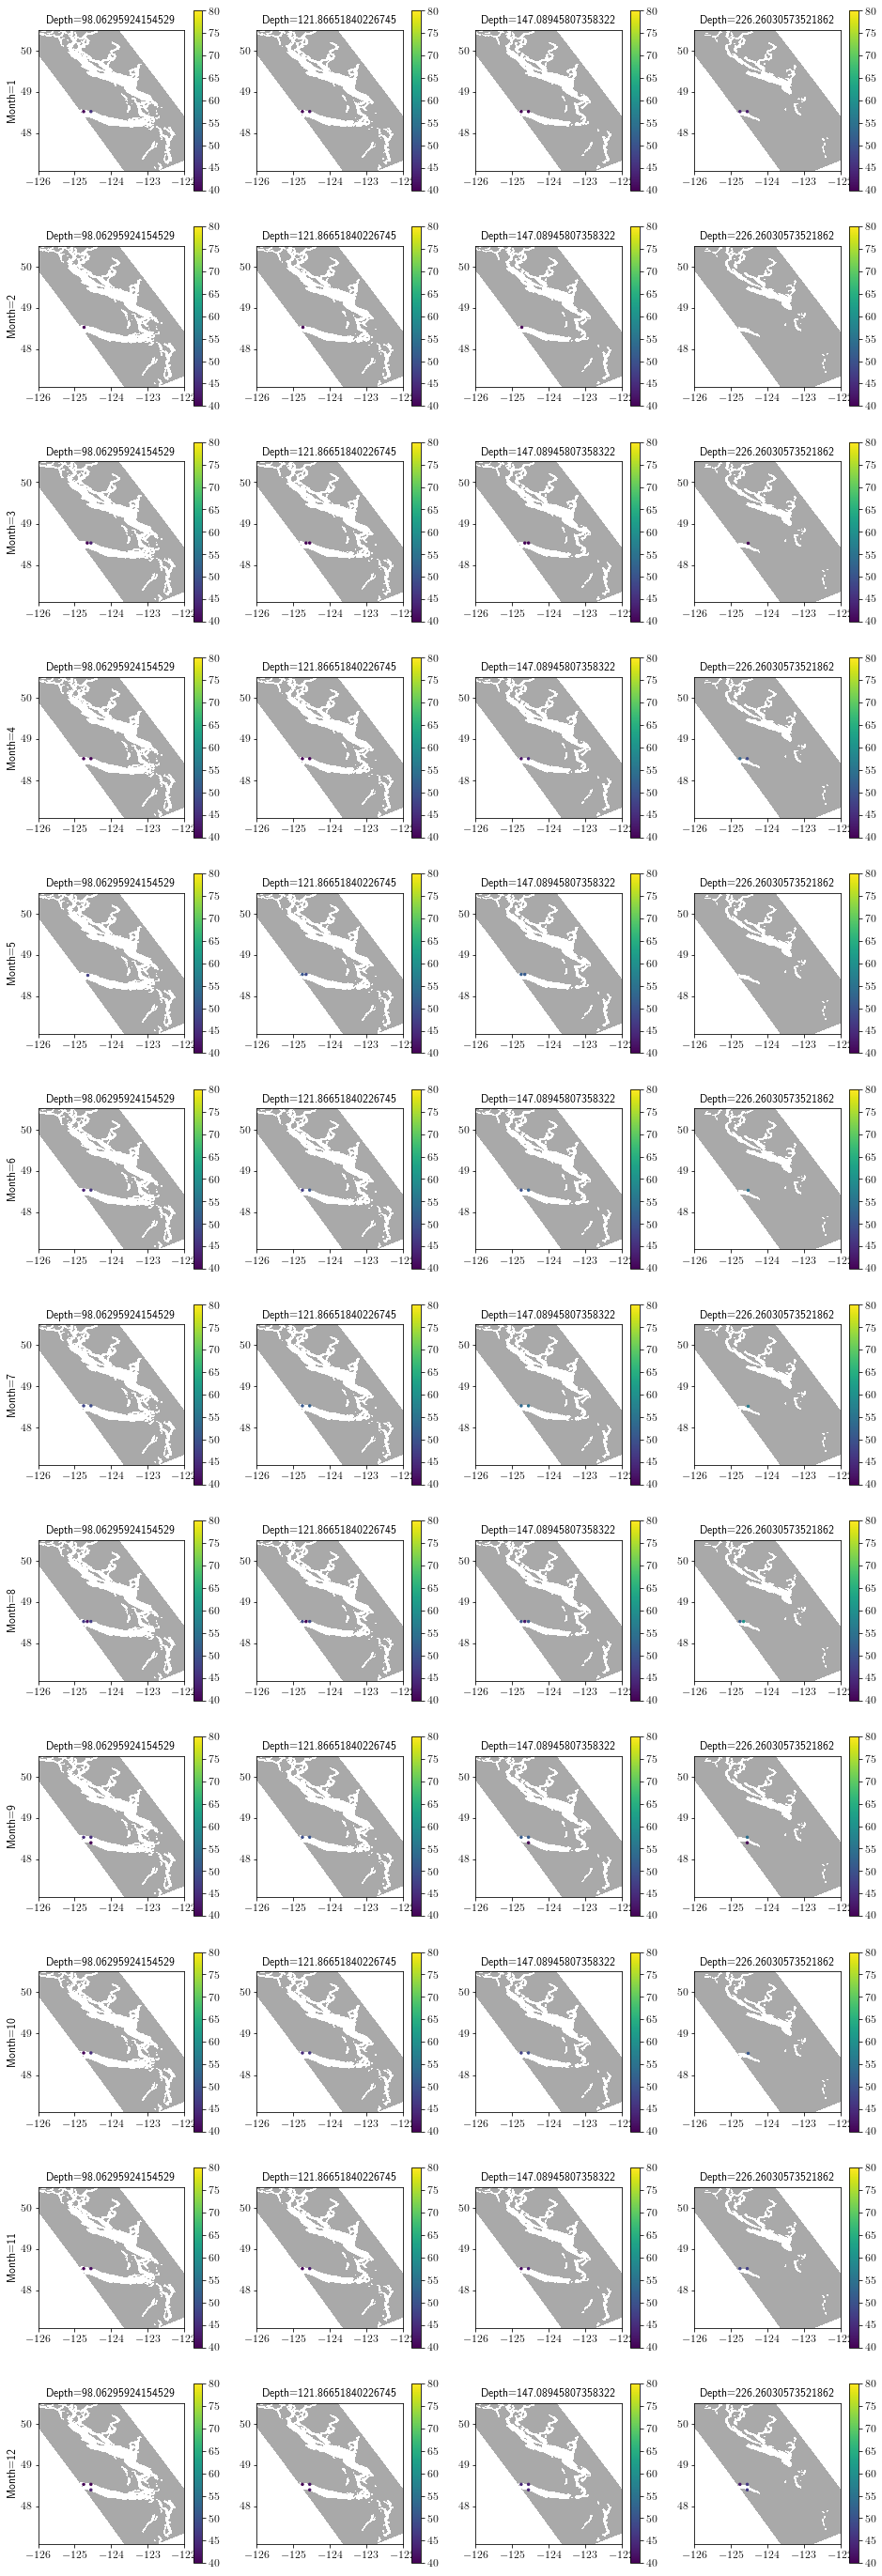

In [13]:
dfW=d1.loc[(d1.Lat>48.15)&(d1.Lat<49)&(d1.Lon>-125)&(d1.Lon<-124.5)]
fig,ax=plt.subplots(12,4,figsize=(16,50))
#kk=30 #36,34,32,30
simin=40
simax=80
for mon in range(1,13):
    iax=ax[mon-1,0]
    kk=26
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','w','w'))
    viz_tools.set_aspect(iax,coords='map')
    idf=dfW.loc[(dfW.k==kk)&(dfW.Si>=0)&(dfW.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_ylabel('Month='+str(mon))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,1]
    kk=27
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','w','w'))
    viz_tools.set_aspect(iax,coords='map')
    idf=dfW.loc[(dfW.k==kk)&(dfW.Si>=0)&(dfW.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,2]
    kk=28
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','w','w'))
    viz_tools.set_aspect(iax,coords='map')
    idf=dfW.loc[(dfW.k==kk)&(dfW.Si>=0)&(dfW.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,3]
    kk=31
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','w','w'))
    viz_tools.set_aspect(iax,coords='map')
    idf=dfW.loc[(dfW.k==kk)&(dfW.Si>=0)&(dfW.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)

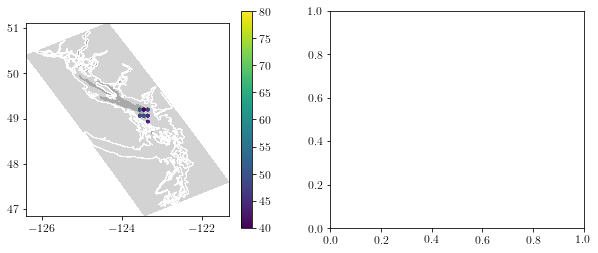

In [14]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
#kk=30 #36,34,32,30
simin=40
simax=80
for mon in range(1,12):
    iax=ax[0];#ax[mon-1,1]
    kk=34
    iax.contour(navlon,navlat,tmask[0,0,:,:],levels=(.5,),linewidths=(.5,),colors=('w','w','w'))
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),colors=('lightgray','darkgray','k'))
    viz_tools.set_aspect(iax,coords='map')
    d1bath=np.array([bathy[j,i] for i,j in zip(d1['i'],d1['j'])])
    df0=d1.loc[(d1.Lon<-123.3)&(d1.Lon>-123.6)&(d1.Lat<49.2)&(d1.Lat>48.85)&(d1.Si>=0)&(d1bath>400)]
    lo,la,mm=binmean(df0,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax,zorder=2)
plt.colorbar(mesh,ax=iax)
    #iax.set_title('Depth='+str(gdept[kk]))

In [15]:
times=np.array([dt.datetime(int(yy),int(mm),int(dd)) for yy,mm,dd in zip(df0.Year,df0.Month,df0.Day)])

In [16]:
# load ONC VENUS data
dfV=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/VENUS/search9384608/'+\
                'Central_StraitofGeorgiaVENUSInstrumentPlatform_CTD_20080924T200000Z_20190702T000000Z-clean_avg1hour.csv',
                skiprows=174,header=None,names=("TimeUTC", "ConductivitySm", "ConductivityQCFlag", "ConductivityCount", 
                                                "Density_kgm3","DensityQCFlag", "DensityCount", "Depth_m", "DepthQCFlag", "DepthCount", 
                                                "PracticalSalinity_psu", "PracticalSalinityQCFlag", "PracticalSalinityCount", 
                                                "Pressure_dbar", "PressureQCFlag", "PressureCount", "Sigmat_kgm3", "SigmatQCFlag", "SigmatCount", 
                                                "Sigmatheta_0dbar_kgm3", "SigmathetaQCFlag", "SigmathetaCount", 
                                                "SoundSpeed_ms", "SoundSpeedQCFlag", "SoundSpeedCount", 
                                                "Temperature_C", "TemperatureQCFlag" , "TemperatureCount"),na_values=' NaN')
    
    #(yyyy-mm-ddThh:mm:ss.fffZ)


In [17]:
dfV.head()

,TimeUTC,ConductivitySm,ConductivityQCFlag,ConductivityCount,Density_kgm3,DensityQCFlag,DensityCount,Depth_m,DepthQCFlag,DepthCount,...,SigmatCount,Sigmatheta_0dbar_kgm3,SigmathetaQCFlag,SigmathetaCount,SoundSpeed_ms,SoundSpeedQCFlag,SoundSpeedCount,Temperature_C,TemperatureQCFlag,TemperatureCount
0,2008-09-24T20:30:00.000Z,NaN,6,31,1025.521921,7,51,NaN,9,0,...,31,NaN,6,31,NaN,6,31,NaN,6,31
1,2008-09-24T21:30:00.000Z,3.357225,7,60,1025.516217,7,104,NaN,9,0,...,60,24.150044,7,60,1486.281100,7,60,8.950633,7,60
2,2008-09-24T22:30:00.000Z,3.356558,7,60,1025.514332,7,98,NaN,9,0,...,60,24.147102,7,60,1486.267783,7,60,8.947650,7,60
3,2008-09-24T23:30:00.000Z,3.356248,7,60,1025.513426,7,100,NaN,9,0,...,60,24.146448,7,60,1486.257167,7,60,8.945462,7,60
4,2008-09-25T00:30:00.000Z,3.353840,7,60,1025.500976,7,60,NaN,9,0,...,60,24.134794,7,60,1486.199167,7,60,8.936242,7,60


In [18]:
dfV.keys()

Index(['TimeUTC', 'ConductivitySm', 'ConductivityQCFlag', 'ConductivityCount',
       'Density_kgm3', 'DensityQCFlag', 'DensityCount', 'Depth_m',
       'DepthQCFlag', 'DepthCount', 'PracticalSalinity_psu',
       'PracticalSalinityQCFlag', 'PracticalSalinityCount', 'Pressure_dbar',
       'PressureQCFlag', 'PressureCount', 'Sigmat_kgm3', 'SigmatQCFlag',
       'SigmatCount', 'Sigmatheta_0dbar_kgm3', 'SigmathetaQCFlag',
       'SigmathetaCount', 'SoundSpeed_ms', 'SoundSpeedQCFlag',
       'SoundSpeedCount', 'Temperature_C', 'TemperatureQCFlag',
       'TemperatureCount'],
      dtype='object')

In [19]:
print(dfV['TimeUTC'][0:2])
timesV=np.array([dt.datetime.strptime(ii[0:19],'%Y-%m-%dT%H:%M:%S') for ii in dfV['TimeUTC']])
print(timesV[0:2])

0    2008-09-24T20:30:00.000Z
1    2008-09-24T21:30:00.000Z
Name: TimeUTC, dtype: object
[datetime.datetime(2008, 9, 24, 20, 30)
 datetime.datetime(2008, 9, 24, 21, 30)]


In [20]:
z=300.0
lon=-123.426075
lat=49.040138
p=gsw.p_from_z(-1*z,lat)
dfV['SA']=gsw.SA_from_SP(dfV['PracticalSalinity_psu'],p,lon,lat)
dfV['CT']=gsw.CT_from_t(dfV['SA'],dfV['Temperature_C'],p)

In [21]:
# load daily ferry Chl
dfCh=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/ferryChl_1d/search9397468/'+\
                'BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20120509T000000Z_20190703T000000Z-clean_avg1day.csv',
                skiprows=102,header=None,names=("TimeUTC", "CDOMFluor_ppb", "CDOMFluorQCFlag", "CDOMFluorCount", 
                     "Chl_ugl", "ChlQCFlag", "ChlCount", "Turbidity_NTU", "TurbidityQCFlag","TurbidityCount", 
                     "Latitude_deg", "LatitudeQCFlag", "LatitudeCount", "Longitude_deg", "LongitudeQCFlag", "LongitudeCount",
                     "Pitch_deg", "PitchQCFlag" , "PitchCount", "Roll_deg", "RollQCFlag" , "RollCount", 
                     "TrueHeading_deg", "TrueHeadingQCFlag" , "TrueHeadingCount"),na_values=' NaN')
    

#(yyyy-mm-ddThh:mm:ss.fffZ)

In [22]:
dfCh.head()

,TimeUTC,CDOMFluor_ppb,CDOMFluorQCFlag,CDOMFluorCount,Chl_ugl,ChlQCFlag,ChlCount,Turbidity_NTU,TurbidityQCFlag,TurbidityCount,...,LongitudeCount,Pitch_deg,PitchQCFlag,PitchCount,Roll_deg,RollQCFlag,RollCount,TrueHeading_deg,TrueHeadingQCFlag,TrueHeadingCount
0,2012-05-09T12:00:00.000Z,11.628890,7,286,1.435923,7,286,9.442631,7,286,...,0,NaN,9,0,NaN,9,0,NaN,9,0
1,2012-05-10T12:00:00.000Z,31.101046,7,3440,5.185789,7,3440,10.456496,7,3440,...,0,NaN,9,0,NaN,9,0,NaN,9,0
2,2012-05-11T12:00:00.000Z,31.691636,7,5698,5.435533,7,5698,9.801661,7,5698,...,0,NaN,9,0,NaN,9,0,NaN,9,0
3,2012-05-12T12:00:00.000Z,28.173778,7,5709,3.192885,7,5709,9.555798,7,5709,...,0,NaN,9,0,NaN,9,0,NaN,9,0
4,2012-05-13T12:00:00.000Z,25.056394,7,3039,2.115449,7,3039,8.769715,7,3039,...,0,NaN,9,0,NaN,9,0,NaN,9,0


In [23]:
timesCh=np.array([dt.datetime.strptime(ii[0:19],'%Y-%m-%dT%H:%M:%S') for ii in dfCh['TimeUTC']])

(735964.0, 736695.0)

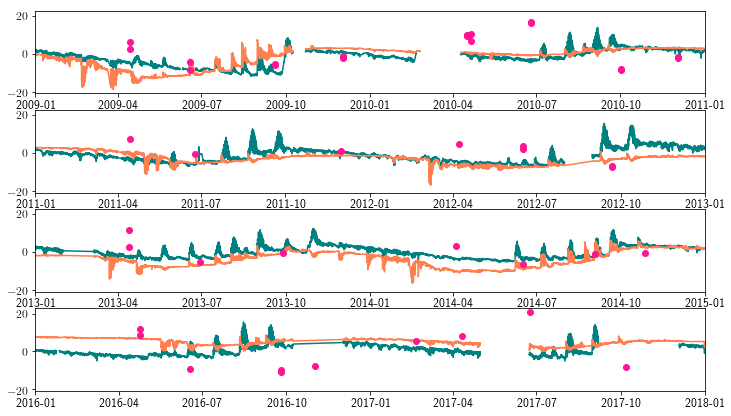

In [24]:
fig,axs=plt.subplots(4,1,figsize=(12,7))
ik=36
ax=axs[0]
ax.plot(timesV,20*(dfV['PracticalSalinity_psu']-np.nanmean(dfV['PracticalSalinity_psu'])),'-',color='teal')
ax.plot(timesV,10*(dfV['Temperature_C']-np.nanmean(dfV['Temperature_C'])),'-',color='coral')
ax.plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']]-np.nanmean(df0.loc[df0.k==ik,['Si']]),'o',color='deeppink')
ax.set_xlim((dt.datetime(2009,1,1),dt.datetime(2011,1,1)))
ax=axs[1]
ax.plot(timesV,20*(dfV['PracticalSalinity_psu']-np.nanmean(dfV['PracticalSalinity_psu'])),'-',color='teal')
ax.plot(timesV,10*(dfV['Temperature_C']-np.nanmean(dfV['Temperature_C'])),'-',color='coral')
ax.plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']]-np.nanmean(df0.loc[df0.k==ik,['Si']]),'o',color='deeppink')
ax.set_xlim((dt.datetime(2011,1,1),dt.datetime(2013,1,1)))
ax=axs[2]
ax.plot(timesV,20*(dfV['PracticalSalinity_psu']-np.nanmean(dfV['PracticalSalinity_psu'])),'-',color='teal')
ax.plot(timesV,10*(dfV['Temperature_C']-np.nanmean(dfV['Temperature_C'])),'-',color='coral')
ax.plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']]-np.nanmean(df0.loc[df0.k==ik,['Si']]),'o',color='deeppink')
ax.set_xlim((dt.datetime(2013,1,1),dt.datetime(2015,1,1)))
ax=axs[3]
ax.plot(timesV,20*(dfV['PracticalSalinity_psu']-np.nanmean(dfV['PracticalSalinity_psu'])),'-',color='teal')
ax.plot(timesV,10*(dfV['Temperature_C']-np.nanmean(dfV['Temperature_C'])),'-',color='coral')
ax.plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']]-np.nanmean(df0.loc[df0.k==ik,['Si']]),'o',color='deeppink')
ax.set_xlim((dt.datetime(2016,1,1),dt.datetime(2018,1,1)))

In [25]:
timesVic=np.array([dt.datetime(int(yy),int(mm),int(dd)) for yy,mm,dd in zip(dfVic.Year,dfVic.Month,dfVic.Day)])

In [26]:
timesW=np.array([dt.datetime(int(yy),int(mm),int(dd)) for yy,mm,dd in zip(dfW.Year,dfW.Month,dfW.Day)])

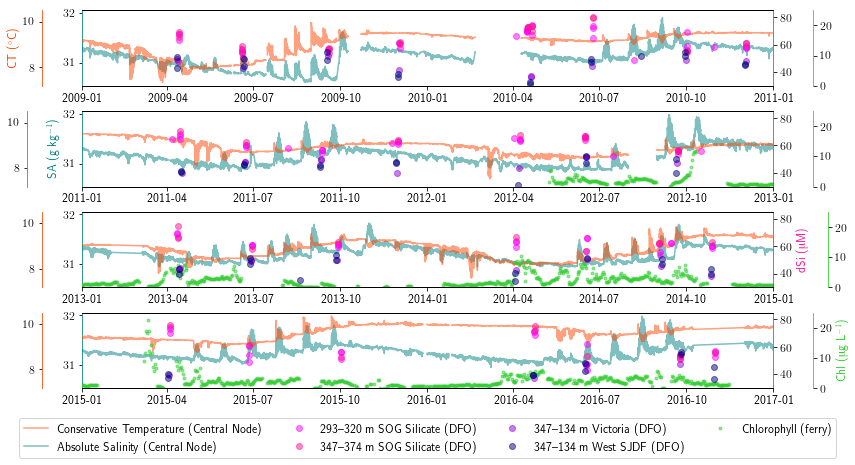

In [55]:
Tcol='orangered'
Scol='teal'
Sicol='deeppink'
Sicol2='fuchsia'
Sicol3='darkviolet'
Sicol4='navy'
Chcol='limegreen'
fig=plt.figure(figsize=(12,7))
h=.15
w=.8
axPos=((.1,.75,w,h),(.1,.55,w,h),(.1,.35,w,h),(.1,.15,w,h))
axSi=dict(); axS=dict(); axT=dict(); axCh=dict()
for i in range(0,4):
    axS[i]=fig.add_axes(axPos[i])
    axT[i]=axS[i].twinx()
    axT[i].yaxis.tick_left()
    axT[i].spines['left'].set_position(('outward', 40))
    axT[i].spines['left'].set_color(Tcol)
    axCh[i]=axS[i].twinx()
    axCh[i].spines['right'].set_position(('outward', 40))
    axCh[i].spines['right'].set_color(Chcol)
    axSi[i]=axS[i].twinx()
    axSi[i].spines['right'].set_color(Sicol)
    axS[i].spines['left'].set_color(Scol)
    #axS[i]=fig.add_axes(axPos[i],sharex=axSi[i])
    #axT[i]=fig.add_axes(axPos[i],sharex=axSi[i])
    #axCh[i]=fig.add_axes(axPos[i],sharex=axSi[i])
    pSi2,=axSi[i].plot(times[df0.k==(ik-2)],df0.loc[df0.k==(ik-2),['Si']],'o',color=Sicol2,alpha=.5)
    pSi,=axSi[i].plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']],'o',color=Sicol,alpha=.5)
    pSiV,=axSi[i].plot(timesVic[dfVic.k==27],dfVic.loc[dfVic.k==27,['Si']],'o',color=Sicol3,alpha=.5)
    pSiW,=axSi[i].plot(timesW[dfW.k==27],dfW.loc[dfW.k==27,['Si']],'o',color=Sicol4,alpha=.5)
    pS,=axS[i].plot(timesV,dfV['SA'],'-',color=Scol,alpha=.5)
    pT,=axT[i].plot(timesV,dfV['CT'],'-',color=Tcol,alpha=.5)
    pCh,=axCh[i].plot(timesCh,dfCh['Chl_ugl'],'.',color=Chcol,alpha=.5)
    axSi[i].set_ylim((30,85))
    axCh[i].set_ylim((0,25))
    axSi[i].spines['left'].set_visible(False)
    axCh[i].spines['left'].set_visible(False)
    axS[i].spines['right'].set_visible(False)
    axT[i].spines['right'].set_visible(False)
axS[0].set_xlim((dt.datetime(2009,1,1),dt.datetime(2011,1,1)))
axS[1].set_xlim((dt.datetime(2011,1,1),dt.datetime(2013,1,1)))
axS[2].set_xlim((dt.datetime(2013,1,1),dt.datetime(2015,1,1)))
axS[3].set_xlim((dt.datetime(2015,1,1),dt.datetime(2017,1,1)))
axT[0].yaxis.set_label_position("left")
axT[0].set_ylabel('CT ($^{\circ}$C)',color=Tcol)
axT[1].spines['left'].set_position(('outward', 55))
axS[1].set_ylabel('SA (g kg$^{-1}$)',color=Scol)
axSi[2].set_ylabel('dSi ($\muup$M)',color=Sicol)
axCh[2].spines['right'].set_position(('outward', 55))
axCh[3].set_ylabel('Chl ($\muup$g L$^{-1}$)',color=Chcol)
plt.legend((pT,pS,pSi2,pSi,pSiV,pSiW,pCh),('Conservative Temperature (Central Node)','Absolute Salinity (Central Node)', 
                str(int(bounds[ik-2,0]))+'--'+str(int(bounds[ik-2,1]))+' m SOG Silicate (DFO)',
                str(int(bounds[ik,0]))+'--'+str(int(bounds[ik,1]))+' m SOG Silicate (DFO)',
                                 str(int(bounds[ik,0]))+'--'+str(int(bounds[27,1]))+' m Victoria (DFO)',
                                 str(int(bounds[ik,0]))+'--'+str(int(bounds[27,1]))+' m West SJDF (DFO)',
                                 'Chlorophyll (ferry)'),loc=8,ncol=4,
          bbox_to_anchor=[0.5,-1,0,0])
fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsEval/dfoDWR.png',dpi=300,transparent=True)

(729755.0, 737060.0)

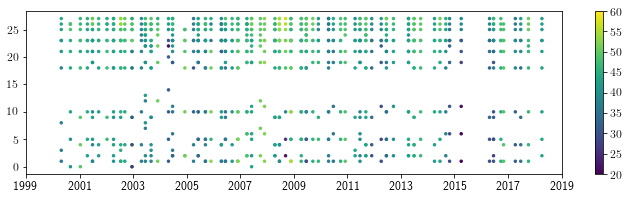

In [28]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
simin=20; simax=60
m1=ax.scatter(timesVic,dfVic.k,c=dfVic.Si,s=6,vmin=simin,vmax=simax)
fig.colorbar(m1)
ax.set_xlim((dt.datetime(1999,1,1),dt.datetime(2019,1,1)))

(729755.0, 737060.0)

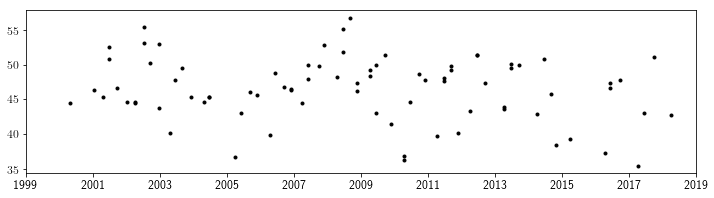

In [29]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
ii=dfVic.k==27
ax.plot(timesVic[ii],dfVic.Si[ii],'k.')
ax.set_xlim((dt.datetime(1999,1,1),dt.datetime(2019,1,1)))

(729755.0, 737060.0)

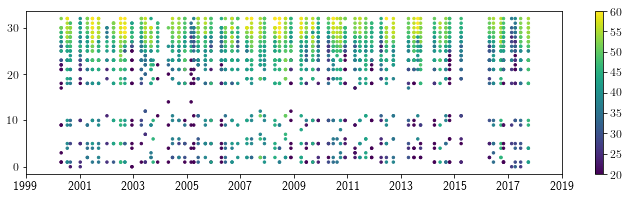

In [30]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
simin=20; simax=60
m1=ax.scatter(timesW,dfW.k,c=dfW.Si,s=6,vmin=simin,vmax=simax)
fig.colorbar(m1)
ax.set_xlim((dt.datetime(1999,1,1),dt.datetime(2019,1,1)))

(729755.0, 737060.0)

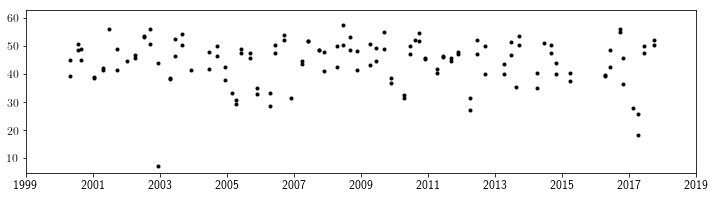

In [31]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
ii=dfW.k==27
ax.plot(timesW[ii],dfW.Si[ii],'k.')
ax.set_xlim((dt.datetime(1999,1,1),dt.datetime(2019,1,1)))

In [32]:
ik=36
ax=axs[0]
ax.plot(timesV,20*(dfV['PracticalSalinity_psu']-np.nanmean(dfV['PracticalSalinity_psu'])),'-',color='teal')
ax.plot(timesV,10*(dfV['Temperature_C']-np.nanmean(dfV['Temperature_C'])),'-',color='coral')
ax.plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']]-np.nanmean(df0.loc[df0.k==ik,['Si']]),'o',color='deeppink')
ax.set_xlim((dt.datetime(2009,1,1),dt.datetime(2011,1,1)))
ax=axs[1]
ax.plot(timesV,20*(dfV['PracticalSalinity_psu']-np.nanmean(dfV['PracticalSalinity_psu'])),'-',color='teal')
ax.plot(timesV,10*(dfV['Temperature_C']-np.nanmean(dfV['Temperature_C'])),'-',color='coral')
ax.plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']]-np.nanmean(df0.loc[df0.k==ik,['Si']]),'o',color='deeppink')
ax.set_xlim((dt.datetime(2011,1,1),dt.datetime(2013,1,1)))
ax=axs[2]
ax.plot(timesV,20*(dfV['PracticalSalinity_psu']-np.nanmean(dfV['PracticalSalinity_psu'])),'-',color='teal')
ax.plot(timesV,10*(dfV['Temperature_C']-np.nanmean(dfV['Temperature_C'])),'-',color='coral')
ax.plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']]-np.nanmean(df0.loc[df0.k==ik,['Si']]),'o',color='deeppink')
ax.set_xlim((dt.datetime(2013,1,1),dt.datetime(2015,1,1)))
ax=axs[3]
ax.plot(timesV,20*(dfV['PracticalSalinity_psu']-np.nanmean(dfV['PracticalSalinity_psu'])),'-',color='teal')
ax.plot(timesV,10*(dfV['Temperature_C']-np.nanmean(dfV['Temperature_C'])),'-',color='coral')
ax.plot(times[df0.k==ik],df0.loc[df0.k==ik,['Si']]-np.nanmean(df0.loc[df0.k==ik,['Si']]),'o',color='deeppink')
ax.set_xlim((dt.datetime(2015,1,1),dt.datetime(2017,1,1)))

(735599.0, 736330.0)

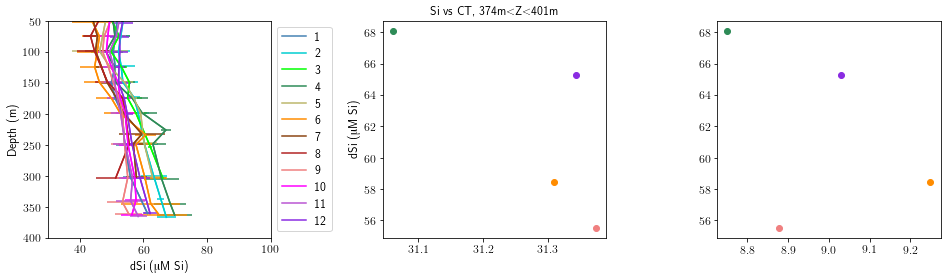

In [33]:
fig,ax=plt.subplots(1,3,figsize=(16,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=37
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs CT, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

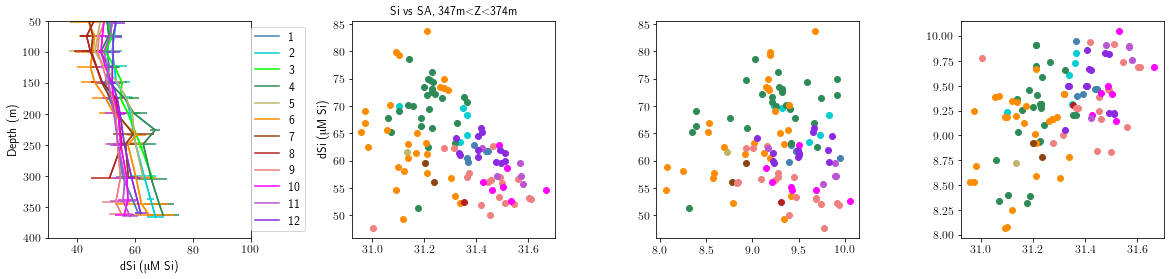

In [34]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=36
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

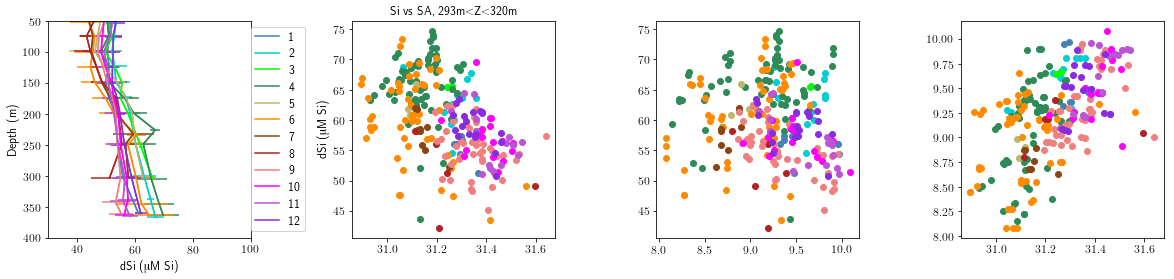

In [35]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=34
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

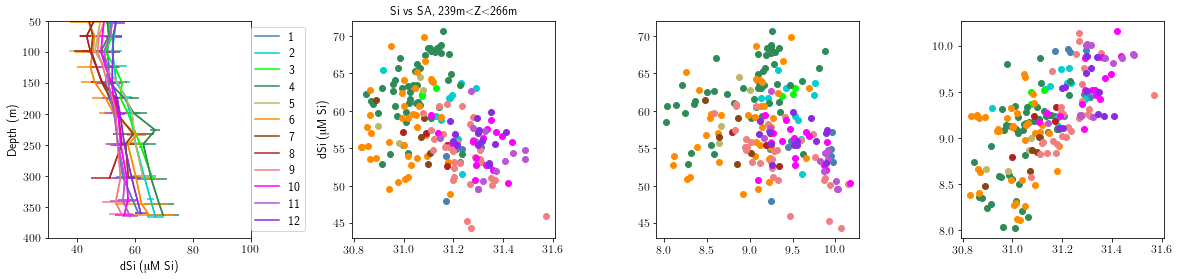

In [36]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=32
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

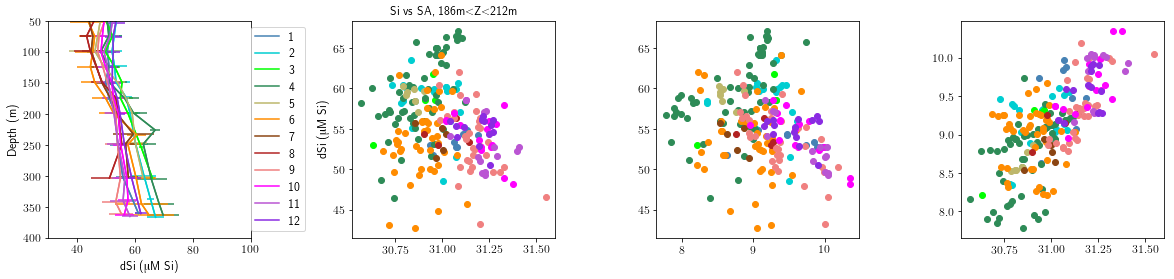

In [37]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=30
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

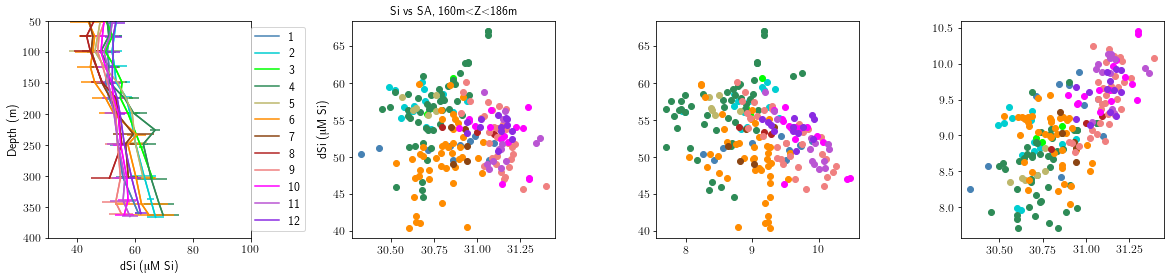

In [38]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=29
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

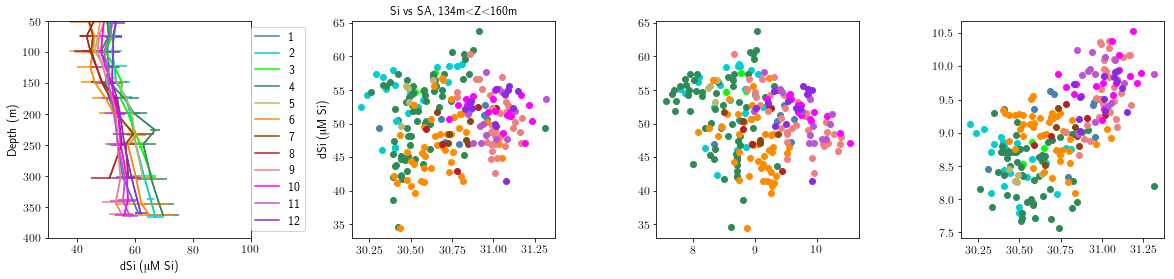

In [39]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=28
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

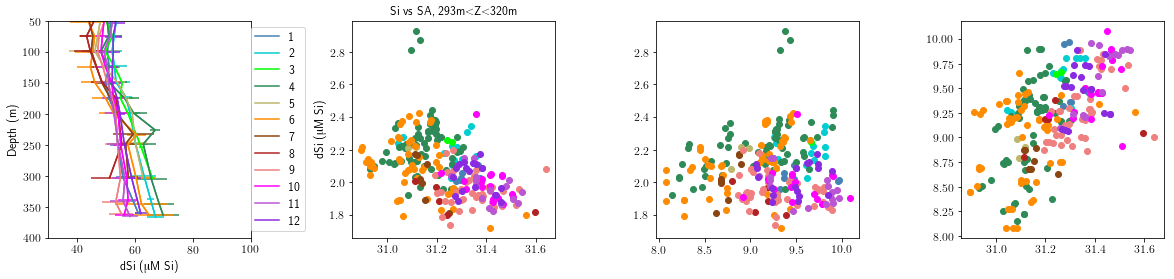

In [40]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=34
    ax[1].plot(groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['AbsSal']],
               groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['Si']].values/groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['N']].values,
               'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['ConsT']],
               groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['Si']].values/groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['N']].values,
               'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['AbsSal']],
               groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['ConsT']].values,
               'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

In [41]:
df0.loc[(df0.k==34)].groupby(['Year'])['Si'].count()

Year
1978.0     1
1996.0     7
1997.0     4
1998.0     6
1999.0     2
2000.0     9
2001.0    11
2002.0    16
2003.0    14
2004.0    11
2005.0    13
2006.0    12
2007.0    11
2008.0    12
2009.0    12
2010.0    20
2011.0    15
2012.0    12
2013.0     9
2014.0    14
2015.0     9
2016.0    12
2017.0    12
2018.0     9
Name: Si, dtype: int64

In [42]:
df0.loc[(df0.k==35)].groupby(['Year'])['Si'].count()

Year
1996.0    3
1997.0    3
1998.0    3
1999.0    1
2000.0    3
2001.0    3
2002.0    3
2003.0    3
2004.0    2
2005.0    2
2006.0    3
2008.0    3
2010.0    4
2011.0    3
2013.0    2
2014.0    3
2015.0    1
2016.0    2
2017.0    4
2018.0    2
Name: Si, dtype: int64

In [43]:
df0.loc[(df0.k==36)].groupby(['Year'])['Si'].count()

Year
1996.0     3
1997.0     2
1998.0     3
1999.0     1
2000.0     3
2001.0     5
2002.0     7
2003.0     9
2004.0     6
2005.0     6
2006.0     5
2007.0     5
2008.0     5
2009.0     8
2010.0    11
2011.0     3
2012.0     5
2013.0     4
2014.0     5
2015.0     3
2016.0     6
2017.0     4
2018.0     2
Name: Si, dtype: int64

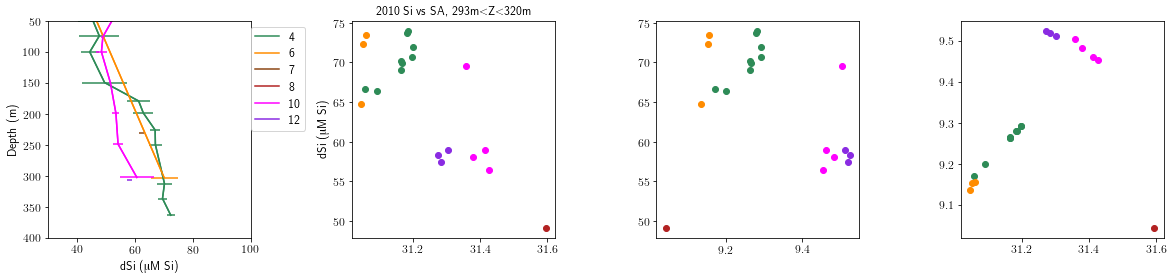

In [44]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2010]
for valm, groupedm in df1.groupby(['Month']):
    ik=34
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('2010 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

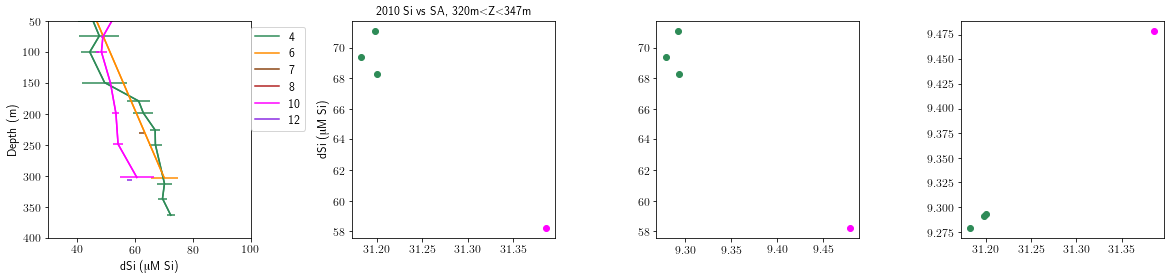

In [45]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2010]
for valm, groupedm in df1.groupby(['Month']):
    ik=35
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('2010 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

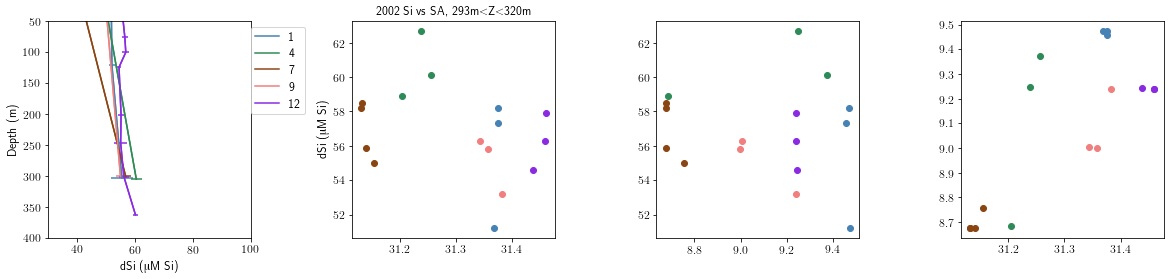

In [46]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2002]
for valm, groupedm in df1.groupby(['Month']):
    ik=34
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title(' 2002 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

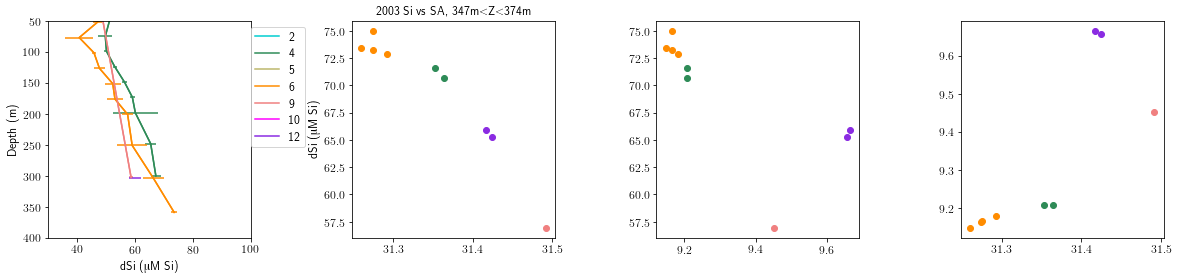

In [47]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2003]
for valm, groupedm in df1.groupby(['Month']):
    ik=36
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title(' 2003 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

In [48]:
df1.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Depth',
       'Ammonium', 'Ammonium_units', 'Chlorophyll_Extracted',
       'Chlorophyll_Extracted_units', 'N', 'Si', 'Silicate_units', 'AbsSal',
       'ConsT', 'Z', 'dtUTC', 'j', 'i', 'k', 'YD'],
      dtype='object')

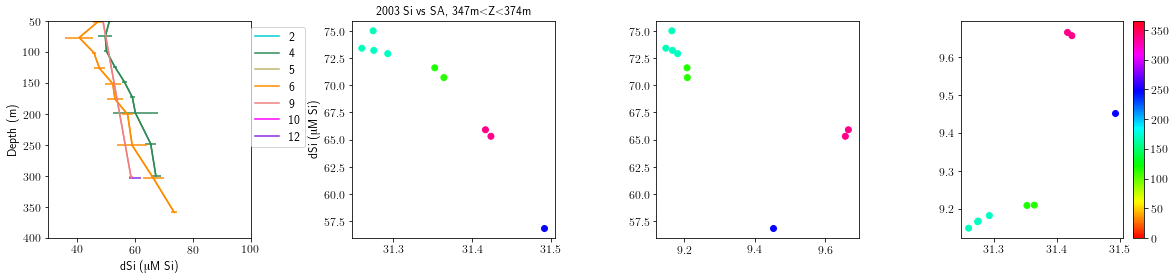

In [49]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2003]
for valm, groupedm in df1.groupby(['Month']):
    ik=36
    cmin=0
    cmax=365
    if np.sum(groupedm.k==ik)>0:
        ax[1].scatter(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],c=groupedm.loc[groupedm.k==ik,['YD']],
                      vmin=cmin,vmax=cmax,cmap=plt.get_cmap('hsv'))
        ax[2].scatter(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],c=groupedm.loc[groupedm.k==ik,['YD']],
                      vmin=cmin,vmax=cmax,cmap=plt.get_cmap('hsv'))
        m=ax[3].scatter(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],c=groupedm.loc[groupedm.k==ik,['YD']],
                        vmin=cmin,vmax=cmax,cmap=plt.get_cmap('hsv'))
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title(' 2003 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')
fig.colorbar(m,ax=ax[3])

In [50]:
df1.loc[df1.k==ik,['Year','Month','Day','Lat','Lon','Pressure','Si','AbsSal','ConsT']]

,Year,Month,Day,Lat,Lon,Pressure,Si,AbsSal,ConsT
40566,2003.0,4.0,26.0,49.163000,-123.550167,371.7,70.7,31.364321,9.209034
40599,2003.0,4.0,27.0,49.162833,-123.549500,375.0,71.6,31.352728,9.208075
40699,2003.0,6.0,19.0,49.164000,-123.548167,352.7,73.4,31.260225,9.148055
40700,2003.0,6.0,19.0,49.164000,-123.548167,369.9,75.0,31.274537,9.164992
40732,2003.0,6.0,20.0,49.163333,-123.549500,352.3,73.2,31.275391,9.166978
40733,2003.0,6.0,20.0,49.163333,-123.549500,372.2,72.9,31.293075,9.181456
40807,2003.0,9.0,5.0,49.162333,-123.547500,372.3,56.9,31.491569,9.452973
40914,2003.0,12.0,4.0,49.163667,-123.547833,353.2,65.9,31.417017,9.665293
40915,2003.0,12.0,4.0,49.163667,-123.547833,373.8,65.3,31.423961,9.656753


(49.16, 49.17)

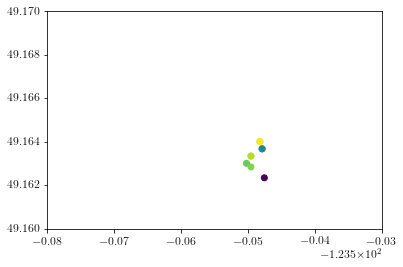

In [51]:
plt.scatter(df1.loc[df1.k==ik,['Lon']],df1.loc[df1.k==ik,['Lat']],c=df1.loc[df1.k==ik,['Si']])
plt.xlim(-123.58,-123.53)
plt.ylim(49.16,49.17)

In [52]:
plt.scatter(xx,xx,c=xx)

NameError: name 'xx' is not defined